## Utils

In [ ]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1-koULT_rZz1E6VJJVYa-hnLXdy6XSZe2'
destination = '/content/data.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
!unzip -q data.zip
!rm -rf data.zip

# Regression with RANSAC for Robust curve fitting

For a given polynomial, \\
$$y_{i}=\beta_{0}+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}+\cdots+\beta_{m} x_{i}^{m}+\varepsilon_{i}(i=1,2, \ldots, n)$$

we can express it in a form of matrix $\mathbf{X}$, a response vector or $\vec{y}$, a parameter vector $\vec{\beta}$, and a vector $\vec{\varepsilon}$ of random errors. The model can be represented as system of linear equations, i.e.



$$\left[\begin{array}{c}y_{1} \\ y_{2} \\ y_{3} \\ \vdots \\ y_{n}\end{array}\right]=\left[\begin{array}{ccccc}1 & x_{1} & x_{1}^{2} & \ldots & x_{1}^{m} \\ 1 & x_{2} & x_{2}^{2} & \ldots & x_{2}^{m} \\ 1 & x_{3} & x_{3}^{2} & \ldots & x_{3}^{m} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_{n} & x_{n}^{2} & \ldots & x_{n}^{m}\end{array}\right]\left[\begin{array}{c}\beta_{0} \\ \beta_{1} \\ \beta_{2} \\ \vdots \\ \beta_{m}\end{array}\right]+\left[\begin{array}{c}\varepsilon_{1} \\ \varepsilon_{2} \\ \varepsilon_{3} \\ \vdots \\ \varepsilon_{n}\end{array}\right]$$

$$or$$

$$\vec{y}=\mathbf{X} \vec{\beta}+\vec{\varepsilon}$$

For this system, we can calculate $\vec{\beta}$ by using the following formula,
$$
\widehat{\vec{\beta}}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \vec{y}
$$

Using **RANSAC**, we want to avoid outliers in our curve fitting, and thus we will calculate multiple $\vec{\beta_i}$s using a set of datapoints. After calculating several $\vec{\beta_i}$ we will find the best value of ${\beta}$ using _least squares_.

**Polynomial Regressor**

In [258]:
from sklearn.utils.random import sample_without_replacement
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sys
import warnings

warnings.filterwarnings("ignore")

class PolynomialRegressor(object):
    def __init__(self, order, coeffs=None):
        """
        Initialize polynomial regressor
        :param order: order of the polynomial
        :param coeffs: coefficients for the regressor
        """
        self.order = order
        self.coeffs = coeffs

    def set_params(self, coeffs=None, random_state=None):
        """
        Sets the coeffiecients
        """
        self.coeffs = coeffs
    def get_params(self):
        """
        Returns regressor coefficients
        """
        return {'coeffs': self.coeffs}

    def fit(self, x, y):
        """
        Fits the given data and sets new coeffs
        :param x: x values
        :param y: y values
        """
        self.coeffs = np.polyfit(x.ravel(), y, self.order)
        
    def predict(self, x):
        """
        Returns predicted values of y as per coefficients
        :param x: Input x values 
        """
        equation = np.poly1d(self.coeffs)
        y_predict = equation(x.ravel())
        return y_predict

    def score(self, x, y):
        """
        Returns Mean squared error
        """
        return np.square(np.subtract(y, self.predict(x))).mean()


In [259]:
class Regression:
    def __init__(self,order, bias=True):
        """
        Initialize regressor
        :param order: order of the polynomial
        :param bias: boolean, True for our case
        """

        self.order = order
        self.bias = bias
        self.beta = np.zeros(order + bias)

    
    def solve(self,x,y,n,iterations=10000):
        '''
        # For 1.5 marks
        Function to solve regression using RANSAC
        :param x: input
        :param y: output
        :param n: number of dataset per iteration
        :param iterations: number of iterations to find best beta 
        '''
        order = self.order
        # polynomial model for reference calculations
        model = PolynomialRegressor(order)
        x = np.expand_dims(x, axis=1)
        # Miniumum number of samples required for estimation and fitting
        min_samples_required = x.shape[1] + 1
        threshold = np.std(y)/2
        random_seed = 0
        # Stop probability for iterations
        probability = 0.99
        
        random_state = np.random.RandomState(random_seed)
        model.set_params(random_state=random_state)

        # Initializing parameters 
        best_no_of_inliers = 1
        best_err = sys.maxsize
        inlier_mask_best = None
        indices = np.arange(n)
        inlier_best_x = None
        inlier_best_y = None

        curr_iteration = 0
        while curr_iteration < iterations:
            curr_iteration += 1
            # choosing random sample set of indices
            sample_indices = sample_without_replacement(n, min_samples_required, random_state=random_state)
            # Fitting the model with choosen values
            model.fit(x[sample_indices], y[sample_indices])
            # Getting predicted y values
            current_y_predict = model.predict(x)
            curr_inlier_mask = np.abs(y - current_y_predict) < threshold
            curr_no_of_inliers = np.sum(curr_inlier_mask)            
            # If the number of inliers are greater than the current best, proceed
            if(curr_no_of_inliers >= best_no_of_inliers):
                curr_inliers_x = x[indices[curr_inlier_mask]]
                curr_inliers_y = y[indices[curr_inlier_mask]]
                this_err = model.score(curr_inliers_x, curr_inliers_y)
                # If error of this state is smaller than the best error, update the states
                if (this_err < best_err):
                    best_no_of_inliers = curr_no_of_inliers
                    best_err = this_err
                    inlier_mask_best = curr_inlier_mask
                    inlier_best_x = curr_inliers_x
                    inlier_best_y = curr_inliers_y
                    # Dynamic updation of iterations, depending on probability
                    inlier_ratio = best_no_of_inliers / float(n) 
                    curr_min_iterations = abs(float(np.ceil(np.log(1 - probability) / np.log(1 - inlier_ratio ** min_samples_required))))
                    iterations = min( iterations, curr_min_iterations)                    

        model.fit(inlier_best_x, inlier_best_y)
        self.x = x
        self.y = y
        self.inlier_mask = inlier_mask_best 
        self.y_ransac_predict = model.predict(x)
        self.beta = model.get_params()['coeffs']
        return self.beta, best_err
    
    def visualize(self,show=False):
        '''
        # For 0.5 marks
        function to visualize datapoints and optimal solution.
        '''
        # Polynomial fitting regressor
        plt.figure(figsize=(12, 4), dpi=150)
        polyReg = PolynomialRegressor(self.order)
        polyReg.fit(self.x, self.y)
        y_poly_predict = polyReg.predict(self.x)

        plt.plot(self.x, self.y, 'bx')
        plt.plot(self.x[self.inlier_mask], self.y[self.inlier_mask], 'go')
        plt.plot(self.x, y_poly_predict, 'b-')
        plt.plot(self.x, self.y_ransac_predict, 'r-')
        plt.legend(['Outliers', 'Inliers', 'Polynomial estimated curve', 'RANSAC estimated curve' ])
        # plt.gcf().set_dpi(150)
        plt.show()

## 2nd Order




Beta Values:  [2.47075953 1.82404132 1.17124553]


Best least square error:  0.20691632256573464




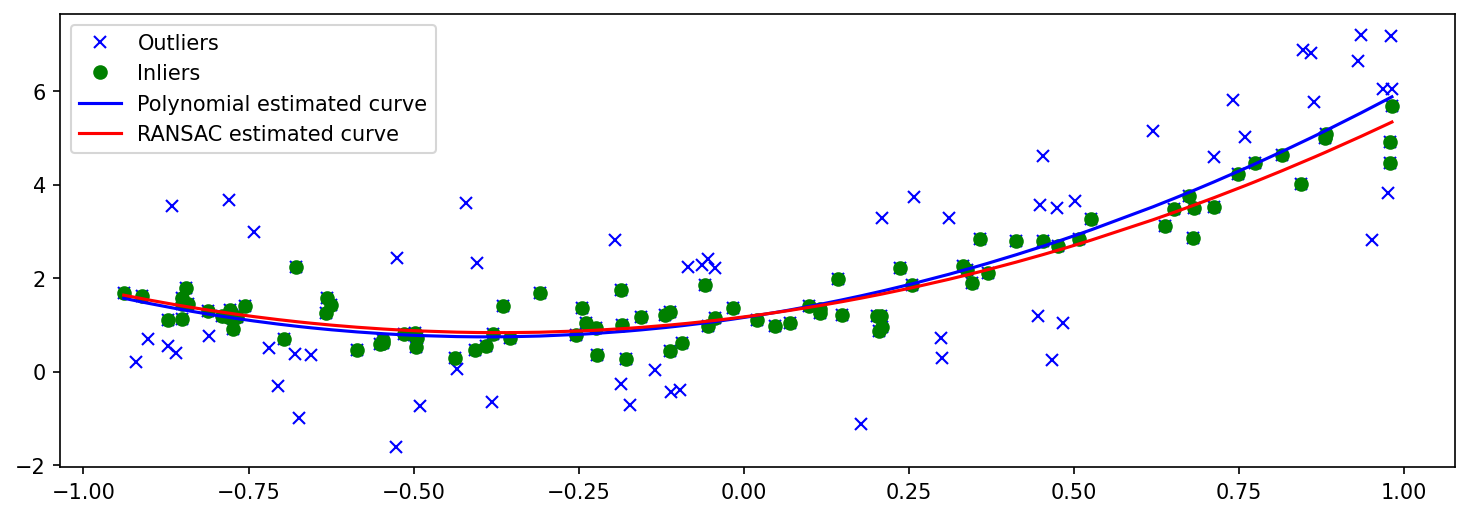

In [260]:
order = 2
data = pd.read_csv("2nd_order.csv").to_numpy()
data = data[data[:, 0].argsort()]

x_vals = data[:,0]
y_vals = data[:,1]

ransac_regressor = Regression(order)
beta, best_err = ransac_regressor.solve(x_vals,y_vals,len(x_vals),100)
print("\n")
print('\033[1m' + "Beta Values: ", beta)
print("\n")
print('\033[1m'+ "Best least square error: ", best_err)
print("\n")
ransac_regressor.visualize()

## 3rd Order



Beta Values:  [4.25021829 2.67019555 1.95150951 1.28776297]


Best least square error:  0.7598863911222009




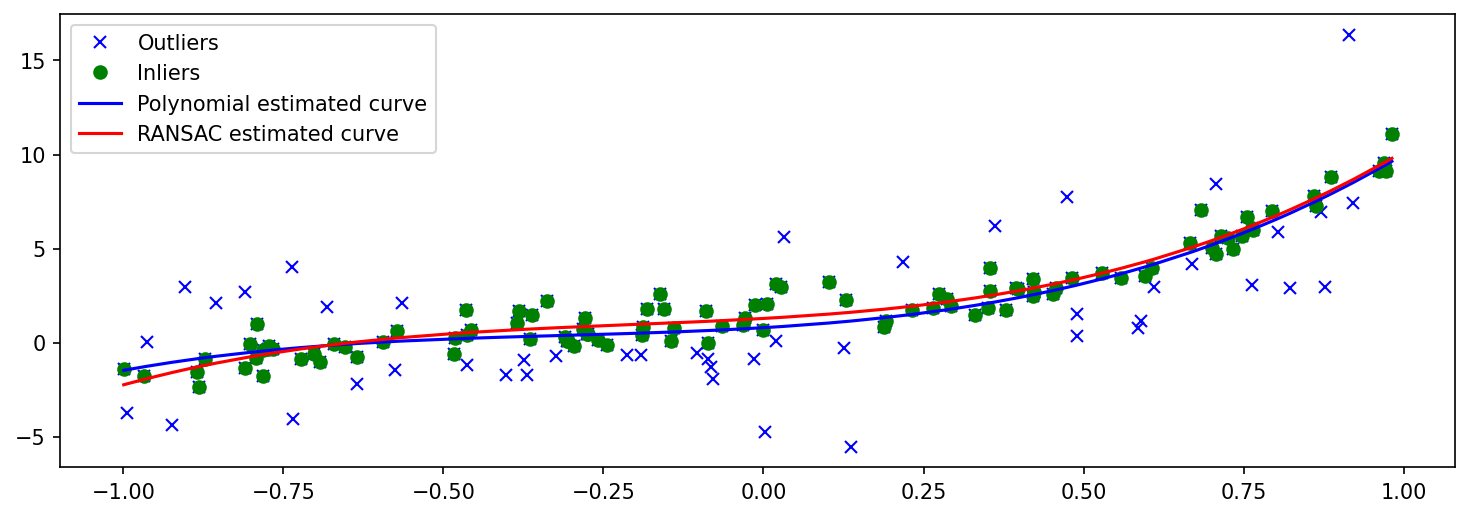

In [261]:
order = 3
data = pd.read_csv("3rd_order.csv").to_numpy()
data = data[data[:, 0].argsort()]

x_vals = data[:,0]
y_vals = data[:,1]

ransac_regressor = Regression(order)
beta, best_err = ransac_regressor.solve(x_vals,y_vals,len(x_vals),100)
print("\n")
print('\033[1m' + "Beta Values: ", beta)
print("\n")
print('\033[1m'+ "Best least square error: ", best_err)
print("\n")
ransac_regressor.visualize()

## 4th Order



Beta Values:  [6.45826409 4.47154354 1.81991654 1.96950278 1.19897157]


Best least square error:  1.0387118261420636




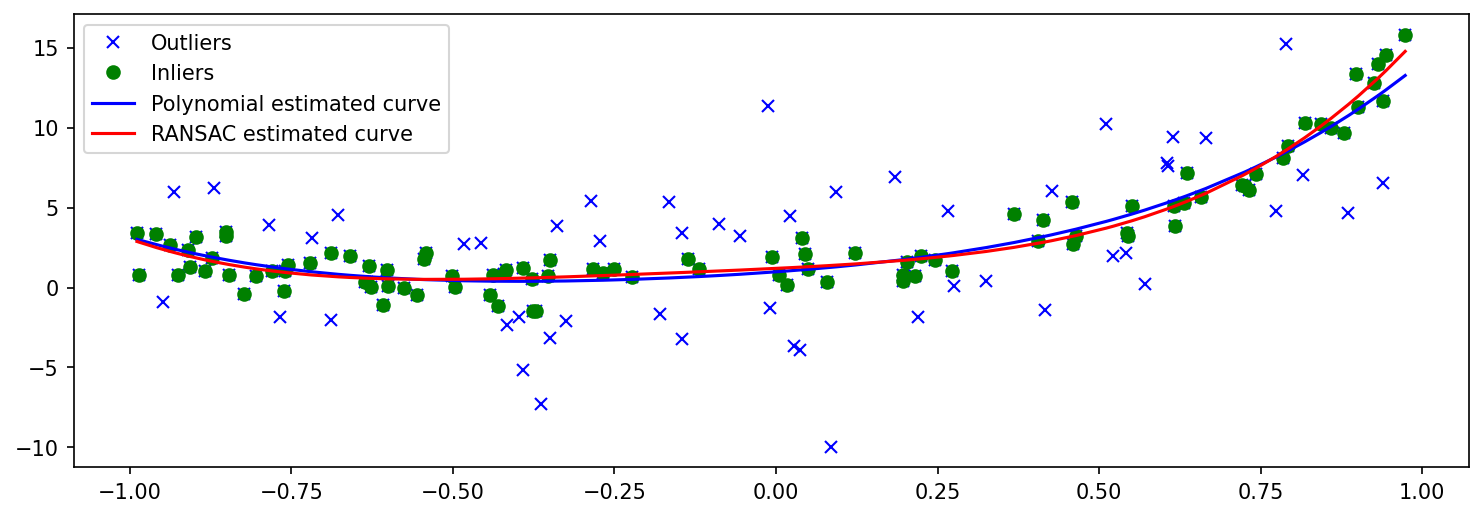

In [262]:
order = 4
data = pd.read_csv("4th_order.csv").to_numpy()
data = data[data[:, 0].argsort()]

x_vals = data[:,0]
y_vals = data[:,1]

ransac_regressor = Regression(order)
beta, best_err = ransac_regressor.solve(x_vals,y_vals,len(x_vals),100)
print("\n")
print('\033[1m' + "Beta Values: ", beta)
print("\n")
print('\033[1m'+ "Best least square error: ", best_err)
print("\n")
ransac_regressor.visualize()

## Report

### What is Linear Regression?

Linear regression is a linear approach for modelling the relationship between a scalar response and one or more dependent/independent variables. It is a commonly used type of predictive analysis. It attempts to model the relationship between variables by fitting a linear equation to observed data

The aim of any linear regression task is to: 

*   Find out if a set of predictor variables do are able to predict the outcome of a dependent variable decently or not.
*   Adjust the predictor variables depending on their significance on the dependent variable 

The regression estimates are then used to explain the relationship between one dependent variable and one or more independent variables.  The simplest form of the regression equation is with one dependent and one independent variable. It is defined as y = a*x + b, y is the dependent variable, a, b are the regression coefficients, and x is the dependent variable. 


### Why RANSAC?

Least squares estimates for regression models are extremely sensitive to outliers. These outliers are observations that do not follow the pattern of the other observations. They can be thought of as a noise in some sense, as they are feature defining values in the outcome. If the outliers voilate some of the standard ordinary least squares assumptions, the validity of the regression results is jeopardised. This is where a need for a robus regression arises. 

Random sample consensus (RANSAC) is an iterative method used to estimate parameters of a mathematical model from a set of observed data that contains outlier. It is a robust regression technique in the sense that the outliers does not affect the output of the algorithm. Where as a standard regression technique will produce misleading results.


### How does RANSAC help curve fitting?



In layman terms, RANSAC tries to demarcate between the, so-called, inliers (data whose distribution can be explained by some set of model parameters, though may be subject to noise) and outliers (which are data that do not fit the model) by repeatedly and randomly sub-sampling the points from the data. The number of times this step is repeated depends on the stopping probability provided. Firsly model parameters are estimated using the sample points only, and then the entire data is checked, if it fits that model or not. A data point will be consided an outlier if it does not fit the system, even after considering some threshold value. 

By doing so the algorithm will eventually come across the right set of data points, and thus determine the inliers and the outliers along with the correct fit. 

